In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import os
#run from repo root...
os.chdir(r"C:/Users/jamed\Documents/repos/lidar_2/LidarClassifcationForFloodModelling")

In [17]:
from structured_data_utils.structuring import GeotiffGeneration, get_combined_geotiff_tensor_and_offset, get_negative_geotiff_tensor_and_offset, get_positive_geotiff_tensor_and_offset

In [18]:
GeotiffGeneration.generate_geotiffs()

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_tensor(tensor):
    image_np = tensor.detach().cpu().numpy().astype(np.float32)

    if image_np.ndim == 3 and image_np.shape[0] <= 4:
        image_np = np.moveaxis(image_np, 0, -1)  # CHW → HWC

    if image_np.ndim == 2:
        image_np = image_np[:, :, None]

    if image_np.shape[2] > 3:
        image_np = image_np[:, :, :3]

    vmin = np.nanmin(image_np, axis=(0, 1), keepdims=True)
    vmax = np.nanmax(image_np, axis=(0, 1), keepdims=True)

    image_np = (image_np - vmin) / (vmax - vmin + 1e-8)

    plt.imshow(image_np.squeeze())
    plt.axis("off")
    plt.show()


#visualize_tensor(combined_tensor)

In [20]:
from structured_data_utils.data import standardise_core_geotiffs, load_combined_pos_neg_df_structured
standardise_core_geotiffs()

In [ ]:
#tensor = get_combined_geotiff_tensor()
#tensor = get_negative_geotiff_tensor()
tensor, offset = get_positive_geotiff_tensor_and_offset()

(374321.48, 8114000.02)
tensor([[-9999., -9999., -9999.,  ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999.,  ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999.,  ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999.,  ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999.,  ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999.,  ..., -9999., -9999., -9999.]])


In [ ]:
from structured_data_utils.structured_data_interfacing import get_segments_with_sliding_window

In [ ]:
get_segments_with_sliding_window()

tensor(nan)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

#gpt visualisation
def show_elevation(elev, title="Elevation", cmap="terrain", vmin=None, vmax=None):
    """
    Visualise a 2D elevation raster with a colormap. NaNs are treated as NoData.
    elev: torch.Tensor (H,W) or numpy array (H,W)
    """
    if isinstance(elev, torch.Tensor):
        elev_np = elev.detach().cpu().numpy()
    else:
        elev_np = np.asarray(elev)

    if elev_np.ndim != 2:
        raise ValueError(f"Expected 2D array (H,W), got shape {elev_np.shape}")

    # Mask NaNs so they render transparent
    m = np.ma.masked_invalid(elev_np)

    cmap_obj = plt.get_cmap(cmap).copy()
    cmap_obj.set_bad(alpha=0.0)  # NaNs transparent

    plt.figure()
    im = plt.imshow(m, cmap=cmap_obj, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.axis("off")
    plt.colorbar(im, label="Elevation")
    plt.show()

# Example:
# show_elevation(tensor_2d, title="DEM", cmap="terrain")
# Optional: clamp color range
# show_elevation(tensor_2d, vmin=120, vmax=160)

In [ ]:
combined = load_combined_pos_neg_df_structured()

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 3358 but got size 16000 for tensor number 1 in the list.

tensor(16.6980)


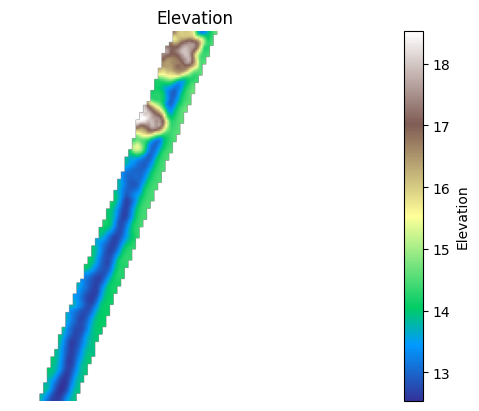

tensor(12.5767)


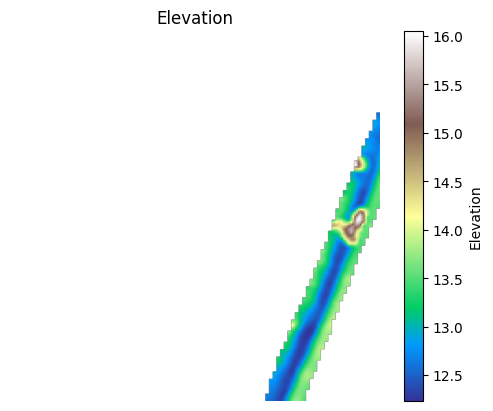

tensor(13.6200)


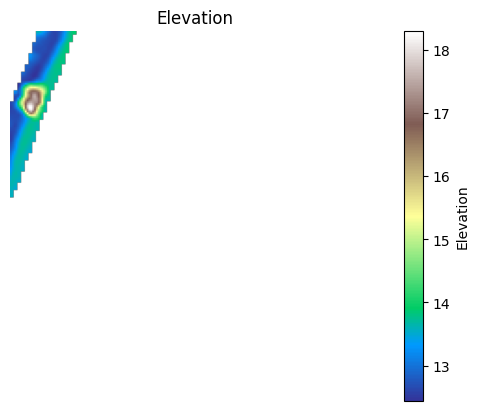

tensor(11.2500)


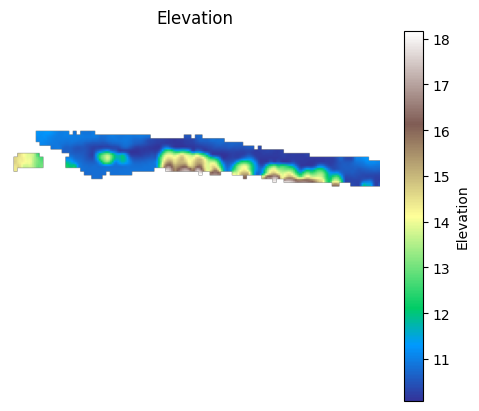

tensor(11.0800)


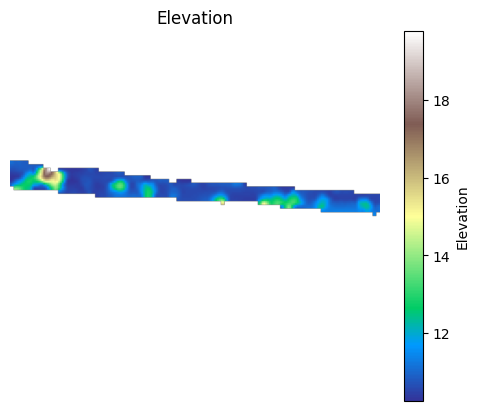

tensor(10.5708)


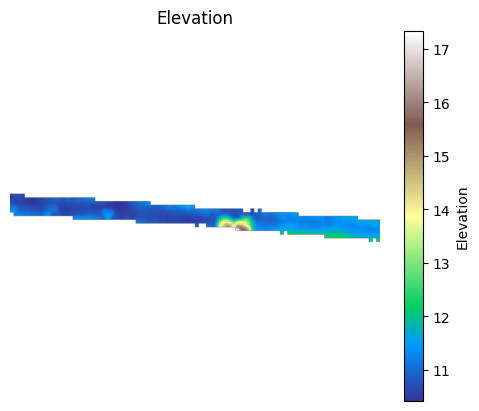

tensor(11.6983)


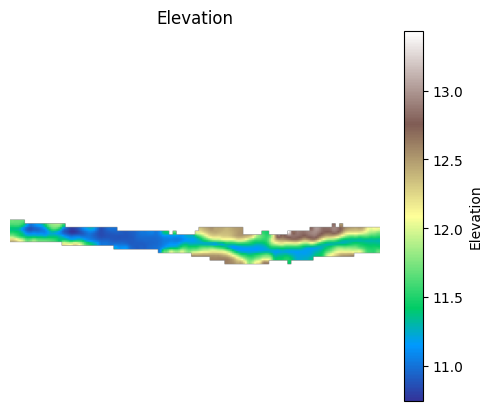

tensor(11.9877)


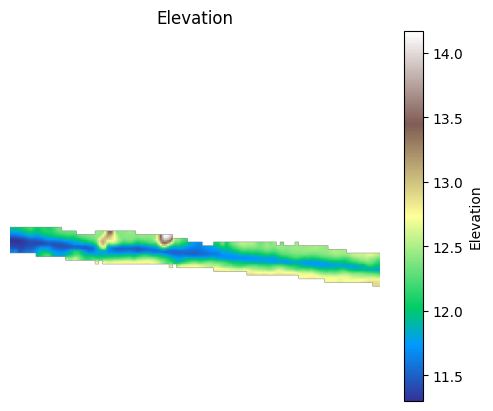

tensor(12.5433)


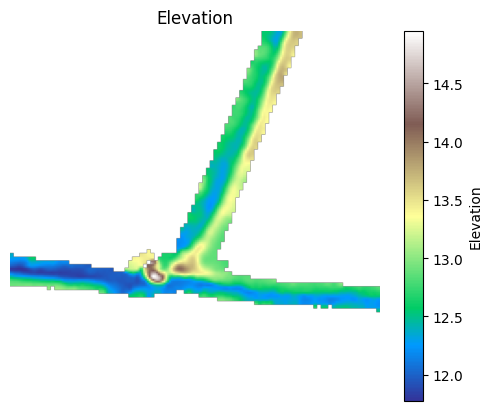

tensor(12.8487)


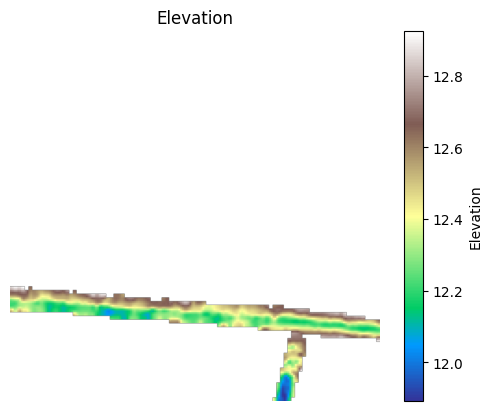

tensor(12.6516)


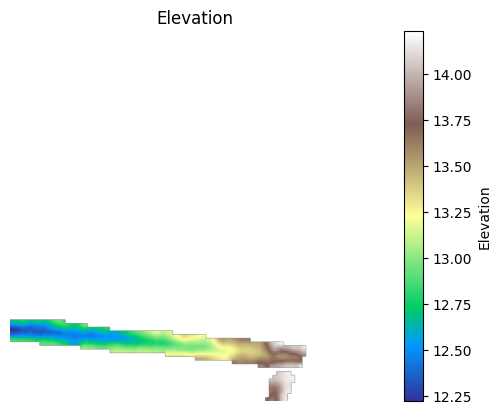

tensor(12.4113)


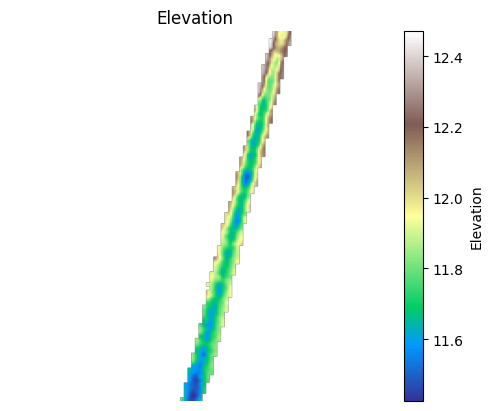

tensor(13.7350)


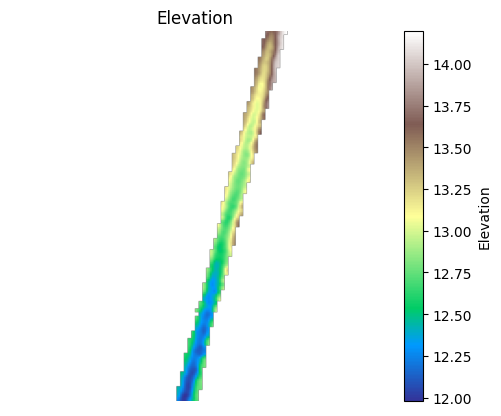

tensor(10.9800)


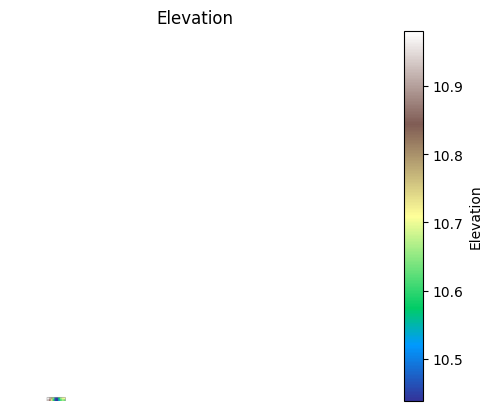

tensor(11.7225)


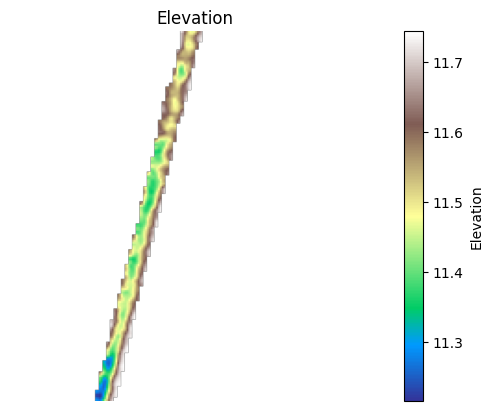

tensor(12.2577)


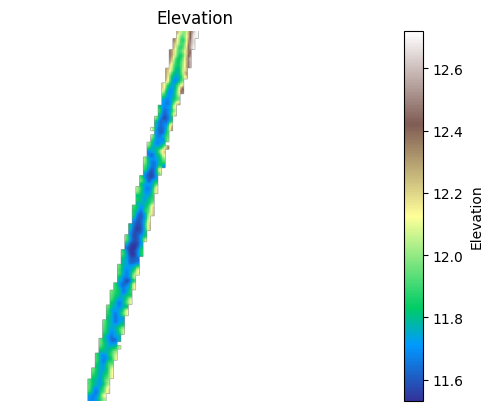

tensor(10.2900)


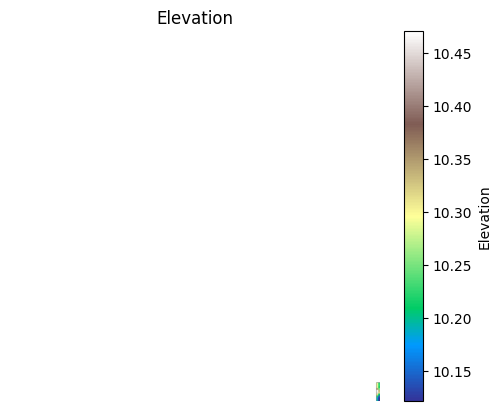

tensor(10.9450)


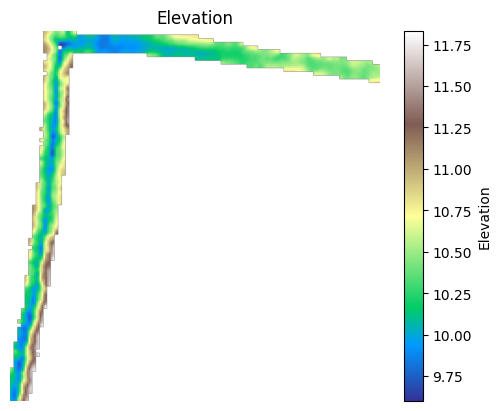

tensor(10.6047)


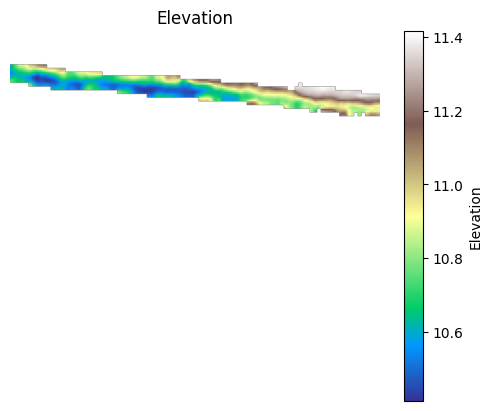

tensor(11.3380)


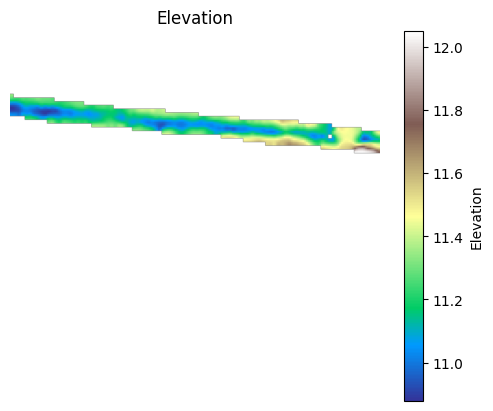

tensor(11.2985)


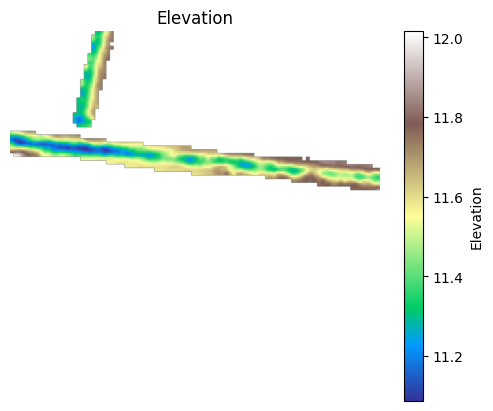

tensor(11.9050)


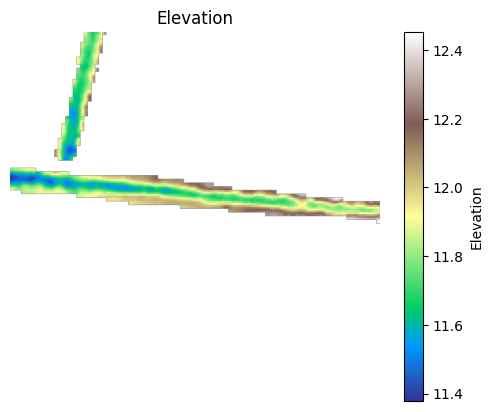

tensor(12.1938)


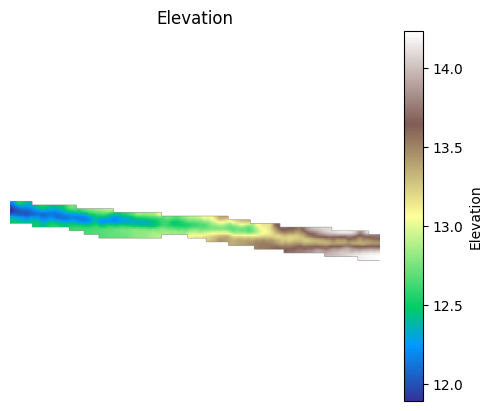

tensor(13.7262)


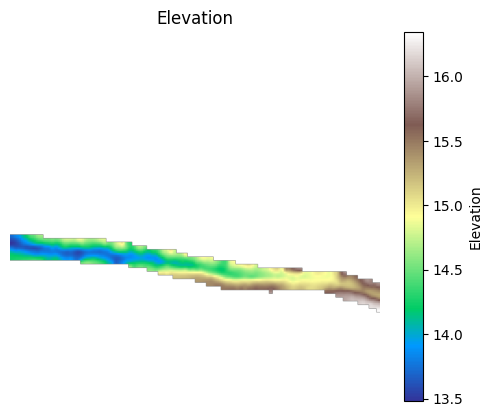

tensor(15.6400)


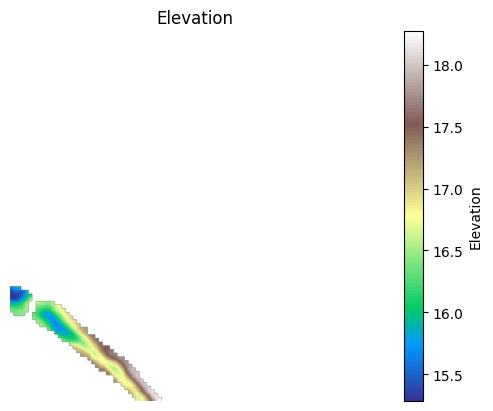

tensor(10.4600)


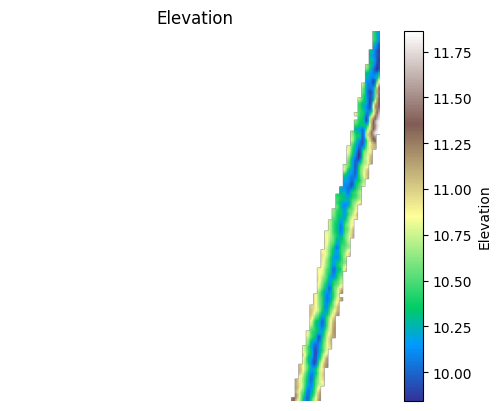

tensor(10.0904)


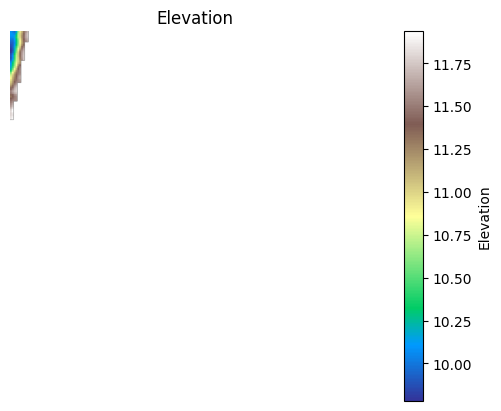

tensor(16.7992)


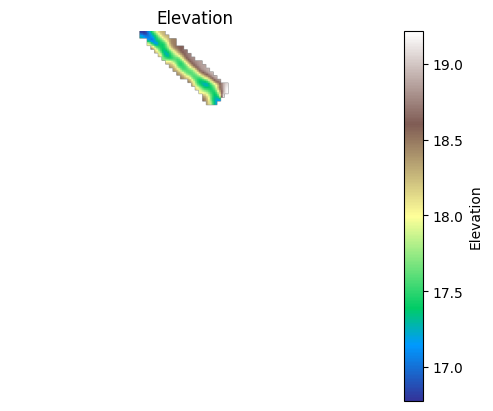

tensor(12.0800)


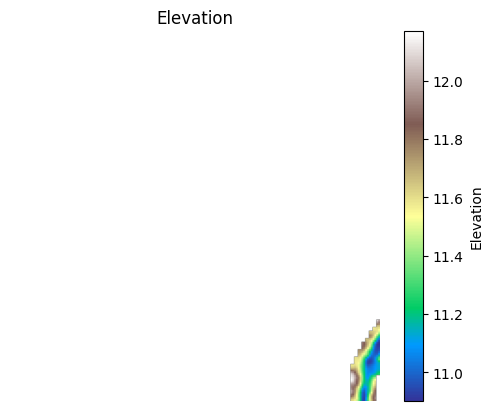

tensor(11.3319)


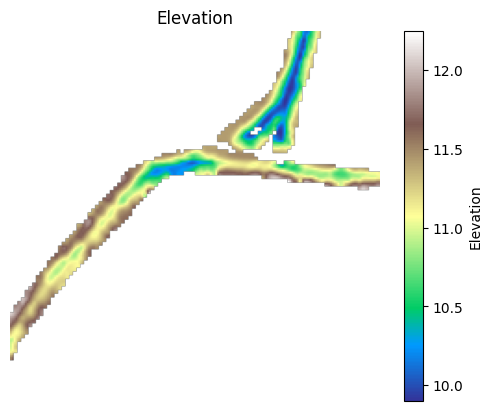

tensor(11.1553)


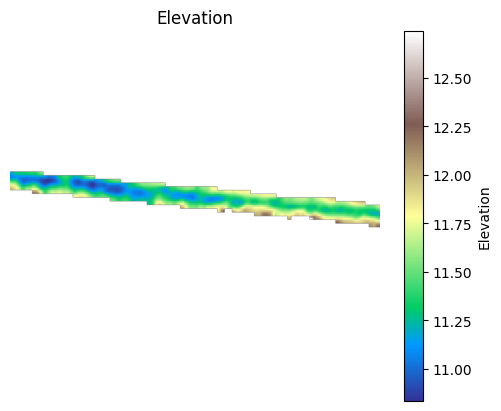

tensor(11.7021)


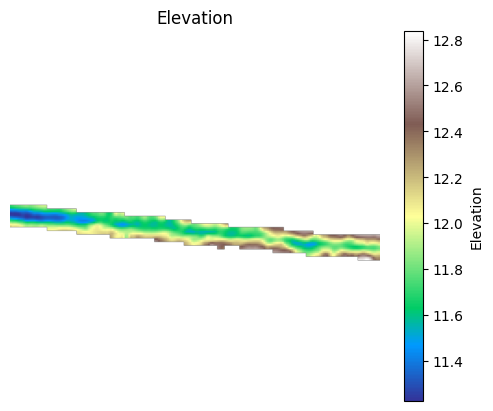

tensor(12.6250)


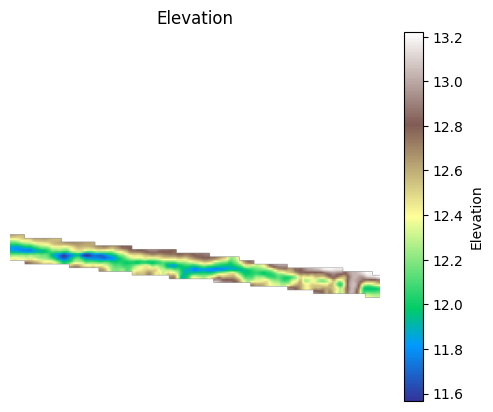

tensor(13.2242)


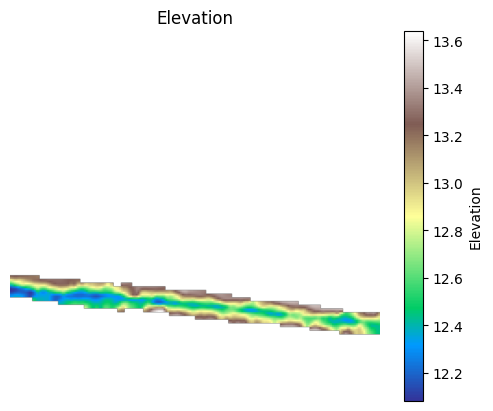

tensor(12.9842)


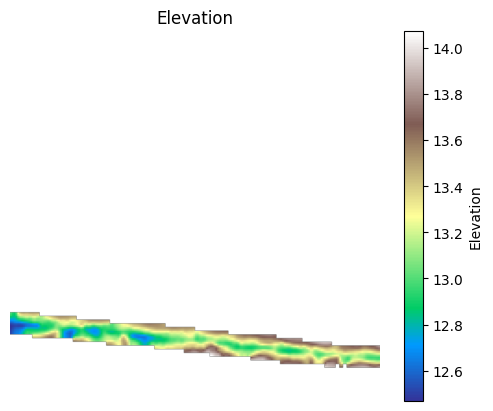

tensor(13.8250)


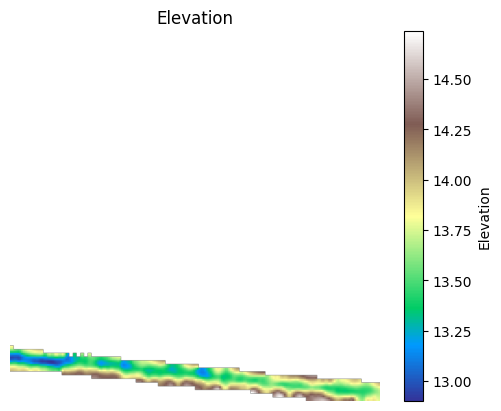

tensor(14.0494)


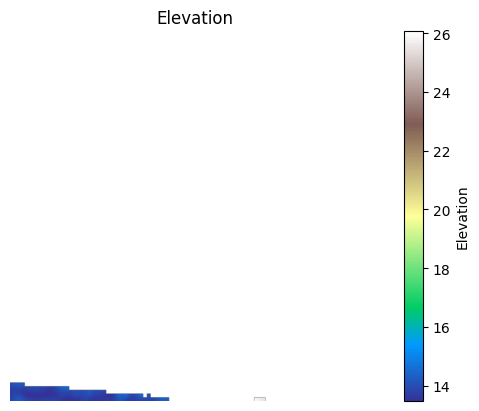

tensor(11.6000)


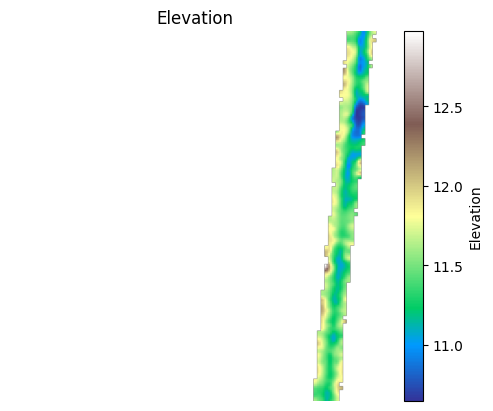

tensor(14.3438)


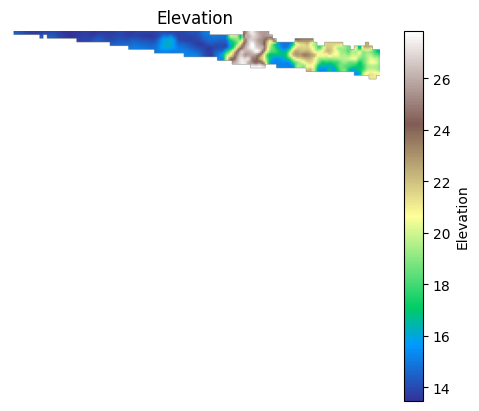

tensor(15.8367)


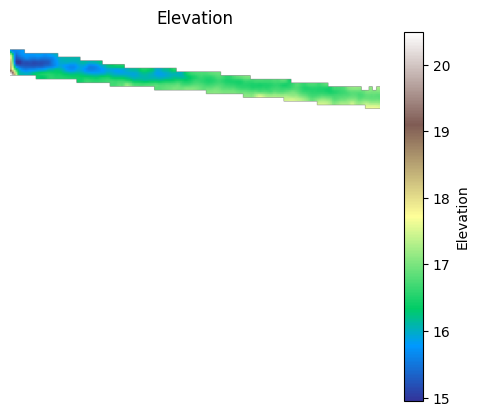

tensor(17.0403)


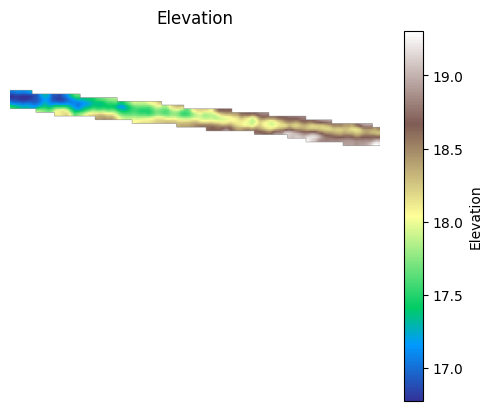

tensor(18.5245)


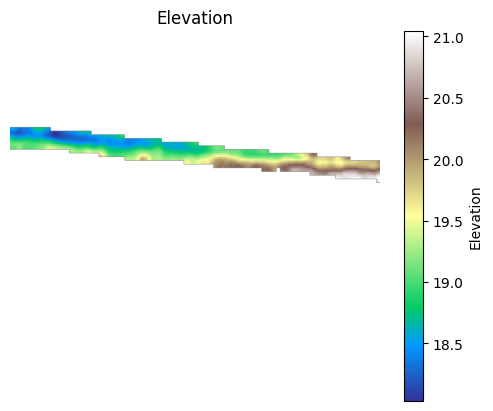

tensor(20.3162)


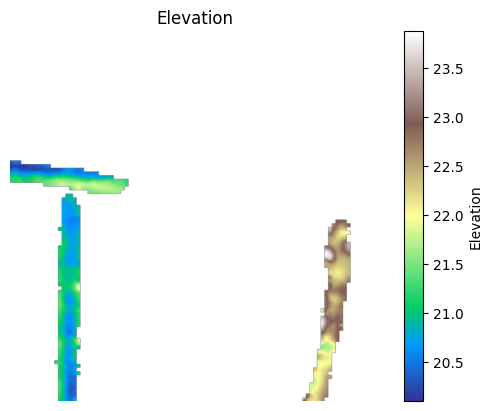

tensor(11.6079)


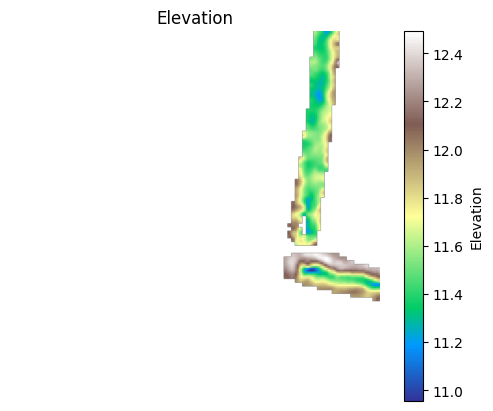

tensor(12.4171)


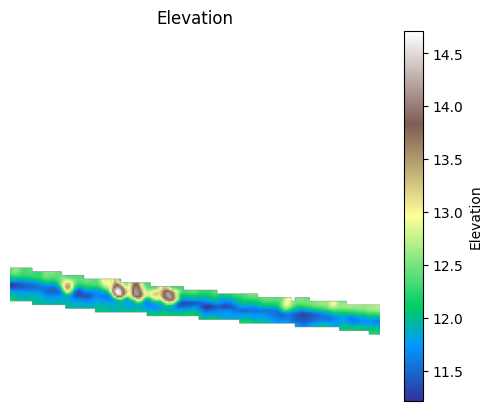

tensor(12.7742)


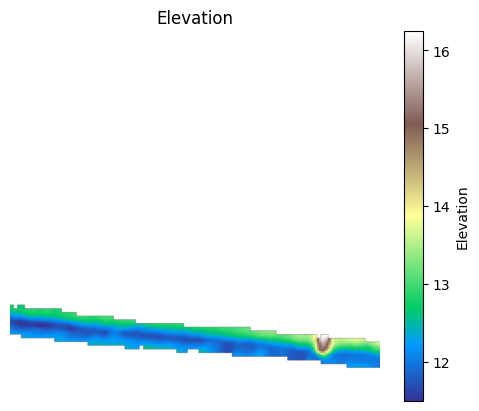

tensor(13.8055)


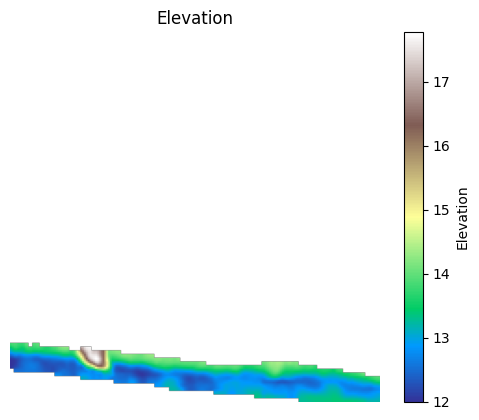

tensor(13.8897)


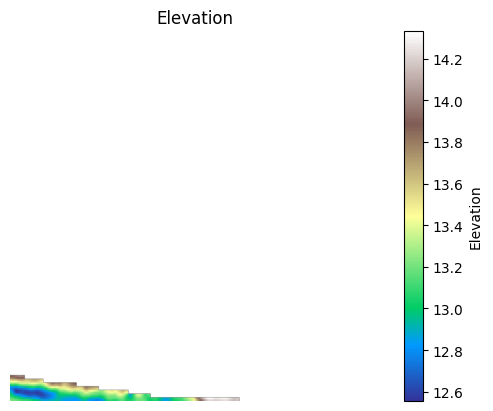

tensor(21.0278)


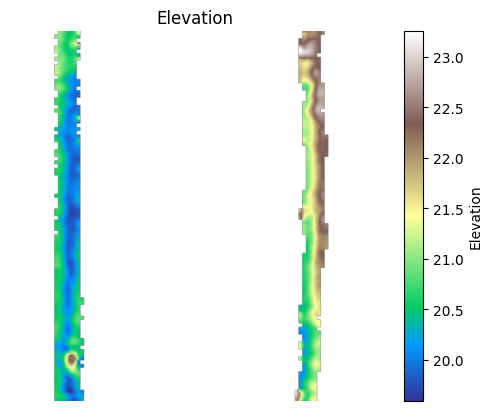

tensor(13.2319)


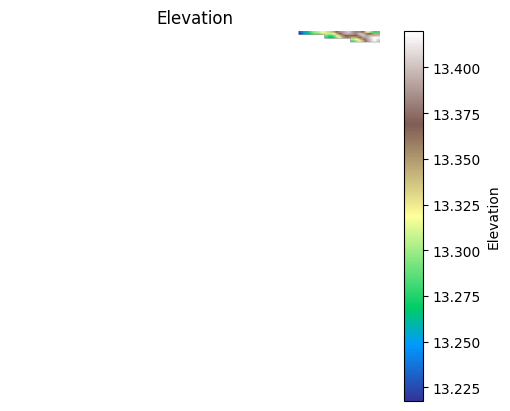

tensor(13.2815)


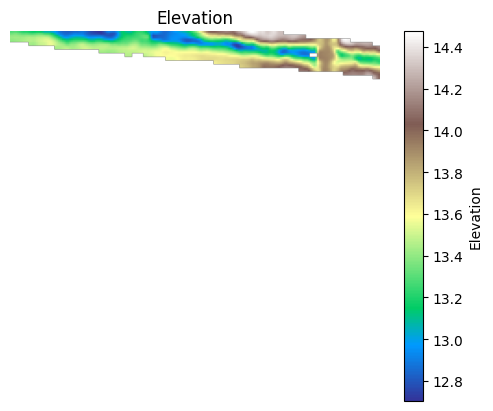

tensor(14.1925)


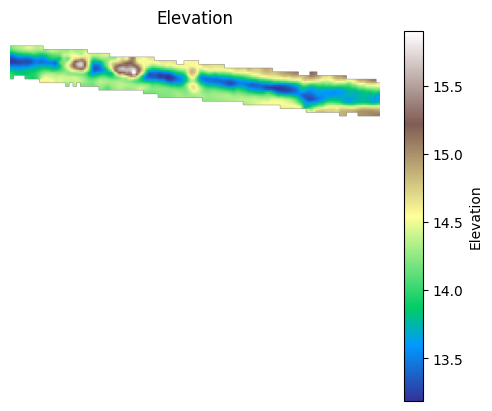

tensor(14.7600)


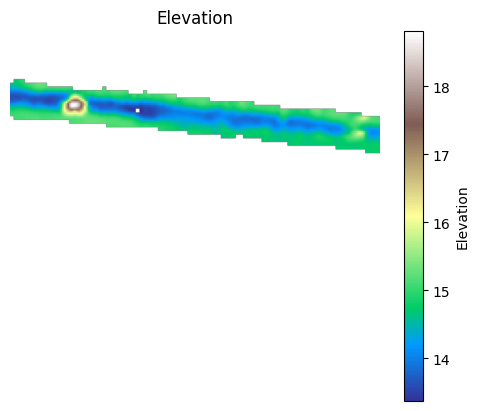

tensor(15.0413)


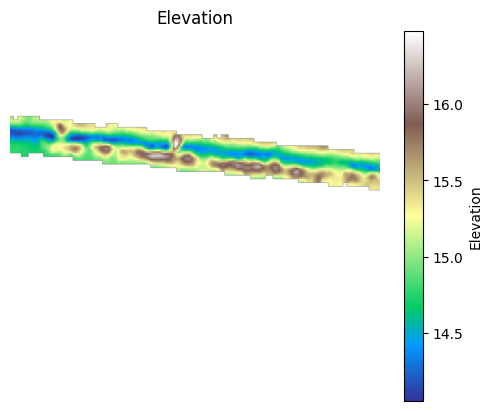

tensor(15.5013)


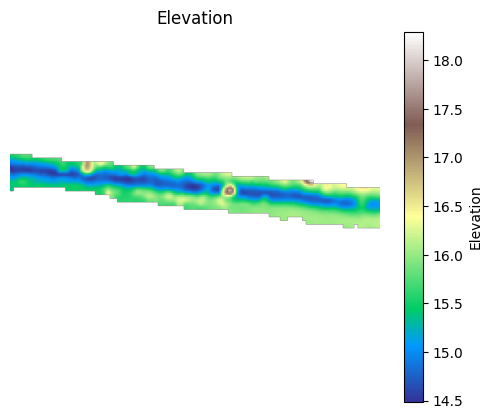

tensor(16.3000)


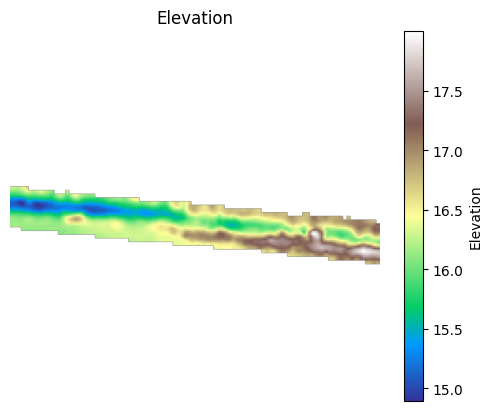

tensor(17.2675)


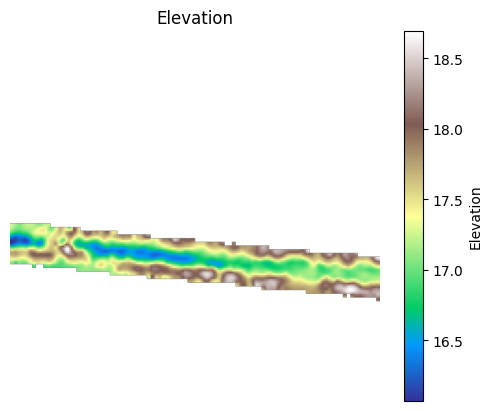

tensor(18.5854)


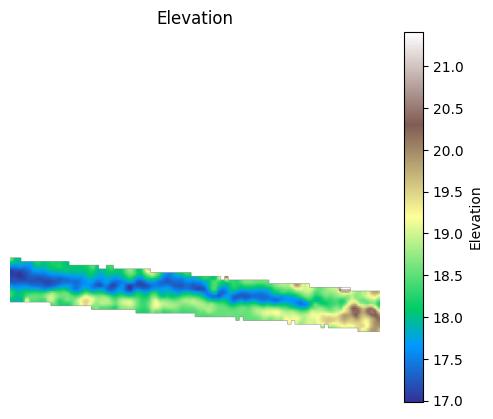

tensor(20.4293)


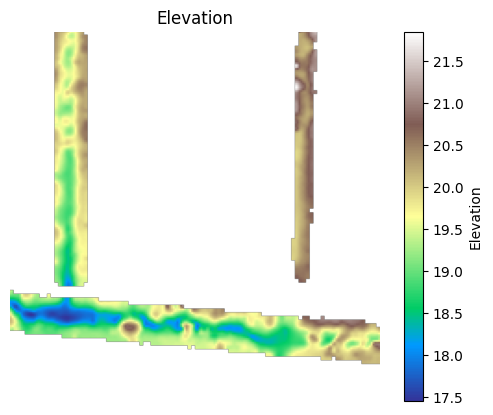

tensor(19.2800)


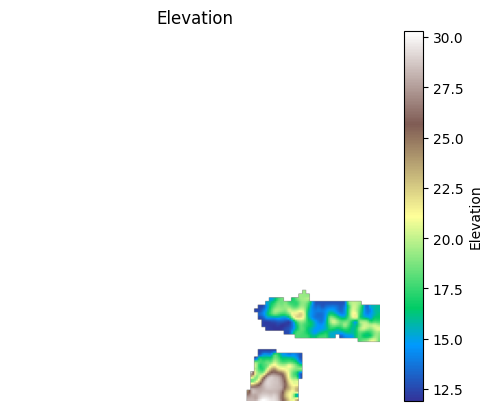

tensor(20.1400)


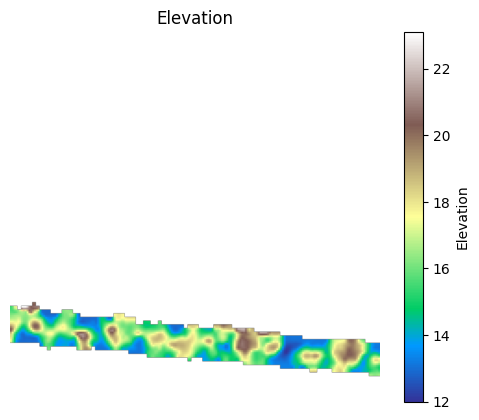

tensor(20.3300)


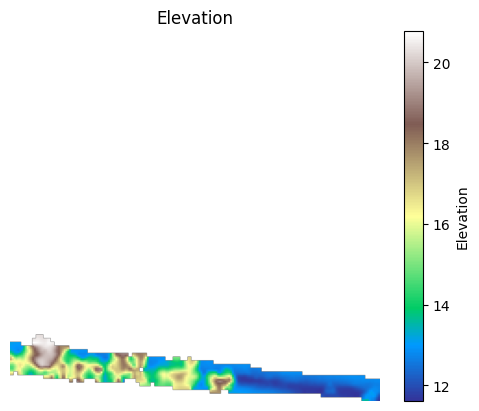

tensor(12.8430)


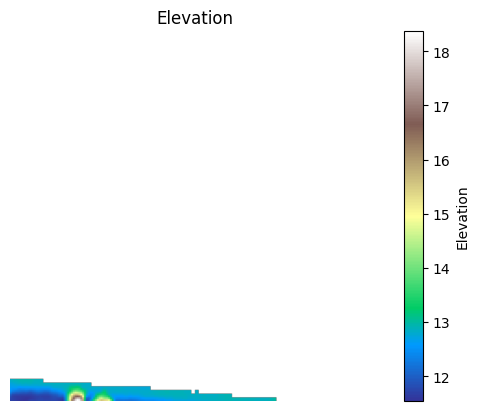

tensor(28.4175)


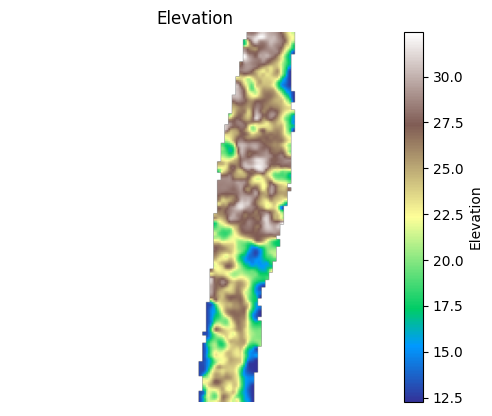

tensor(14.7206)


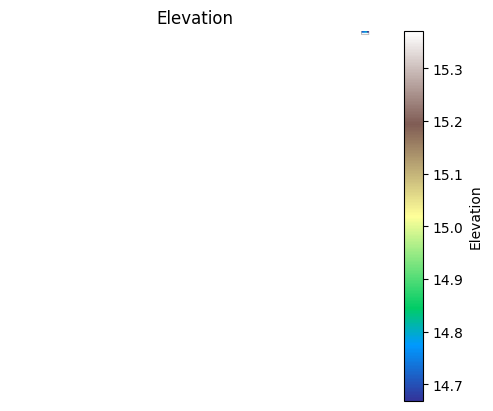

tensor(11.8662)


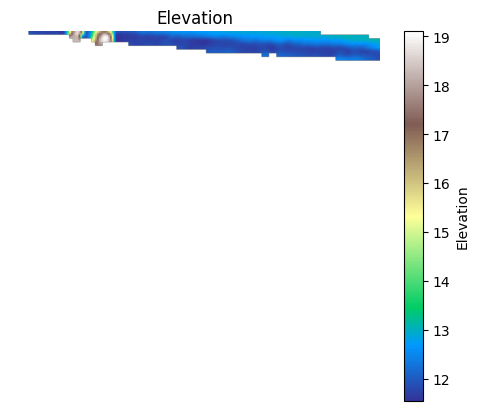

tensor(13.0725)


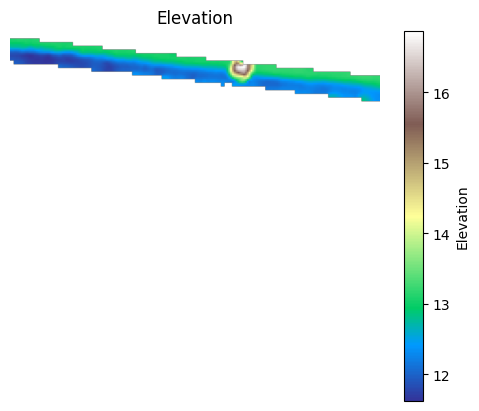

tensor(13.1935)


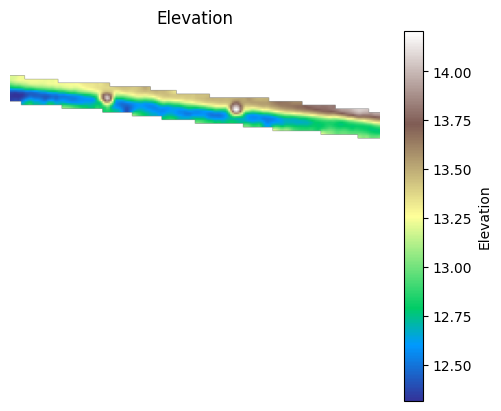

tensor(13.9575)


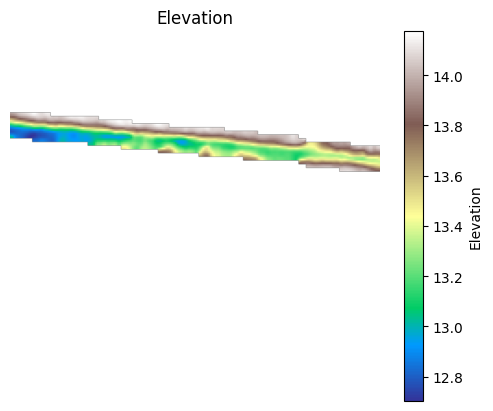

tensor(14.0837)


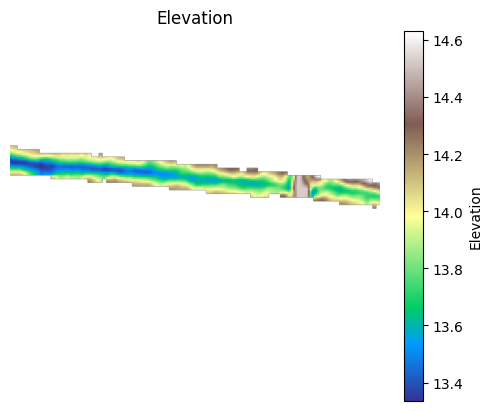

tensor(14.4646)


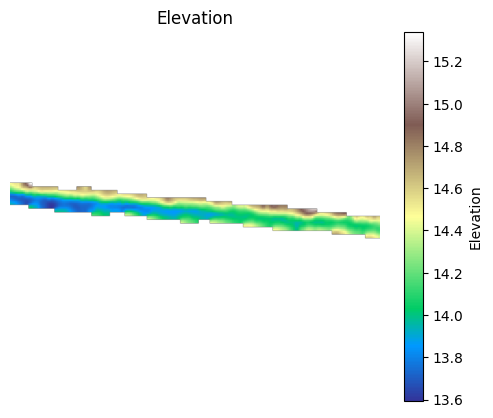

tensor(14.6292)


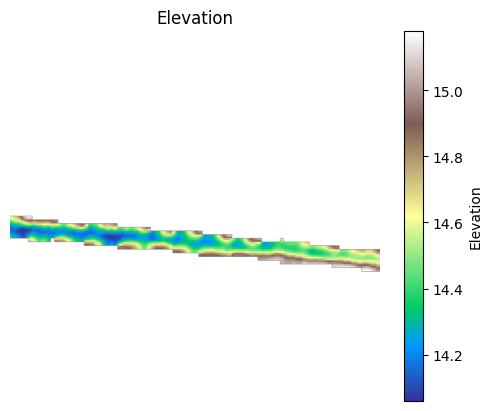

tensor(14.8800)


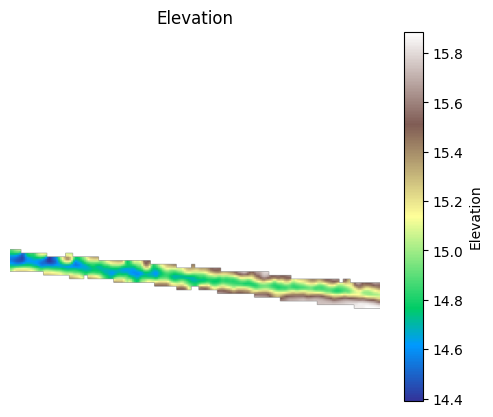

tensor(15.5900)


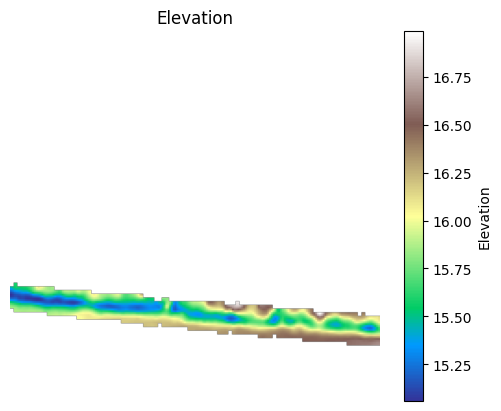

tensor(16.2122)


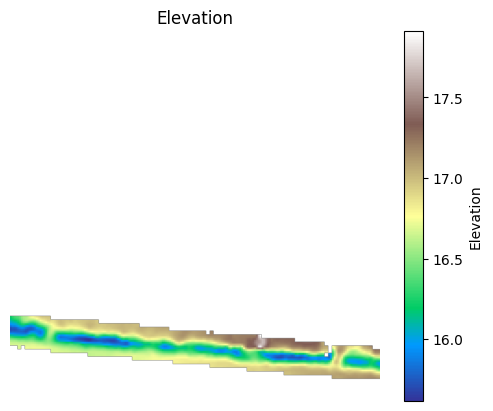

tensor(17.2550)


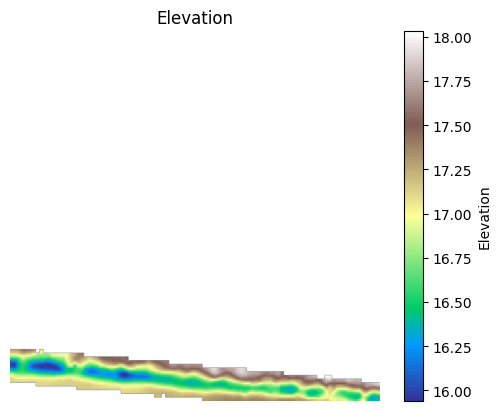

tensor(17.9539)


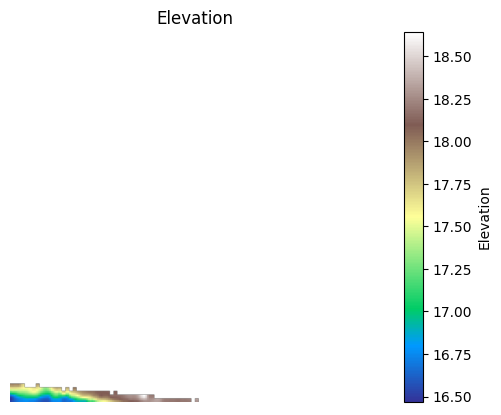

tensor(12.8938)


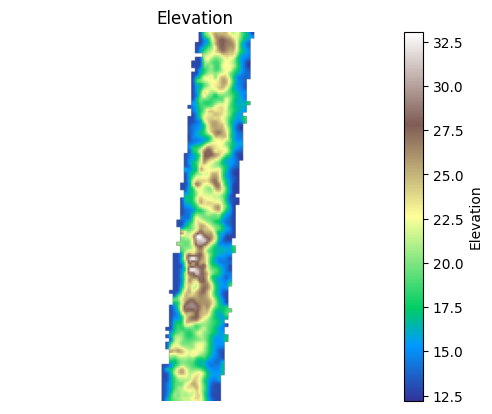

tensor(17.3921)


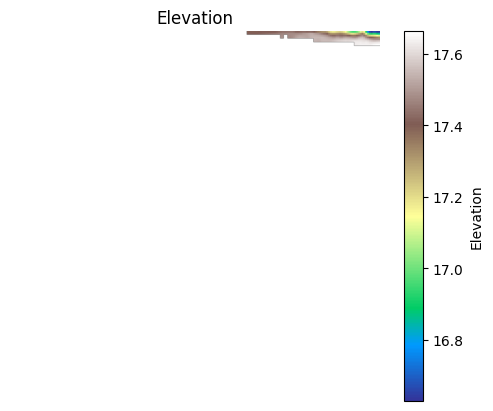

tensor(16.6719)


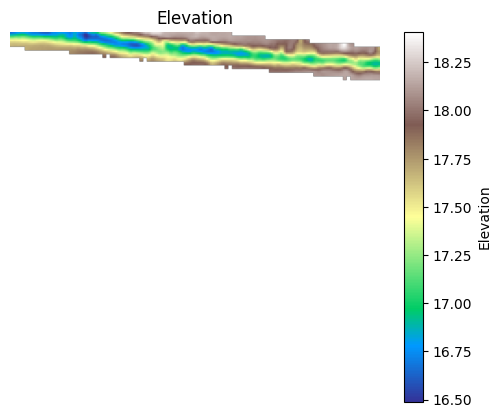

tensor(17.7101)


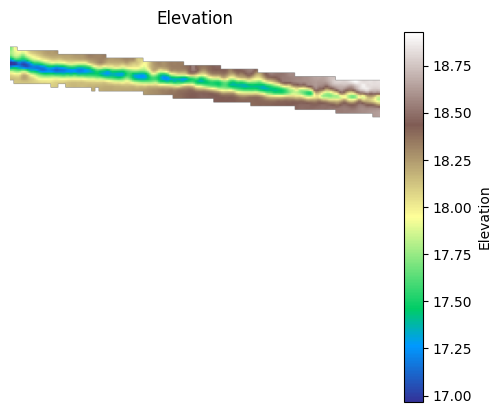

tensor(13.0325)


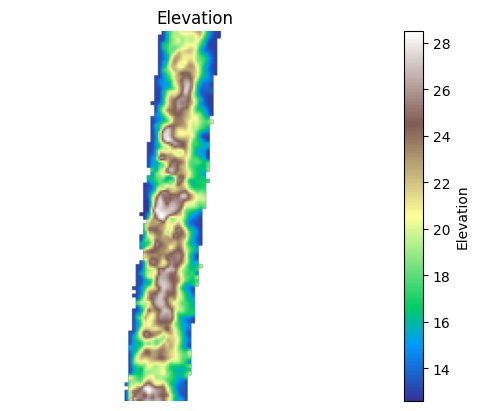

tensor(13.2250)


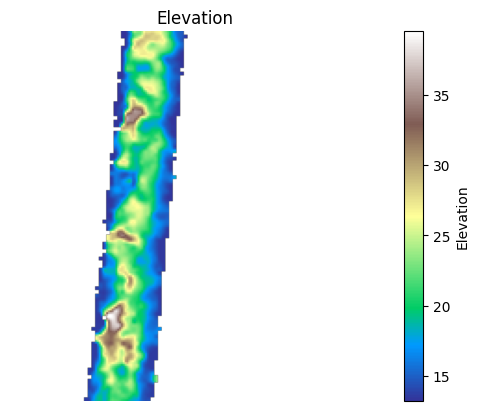

tensor(13.7296)


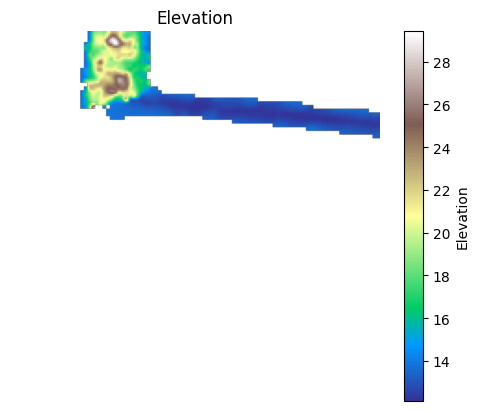

tensor(13.4050)


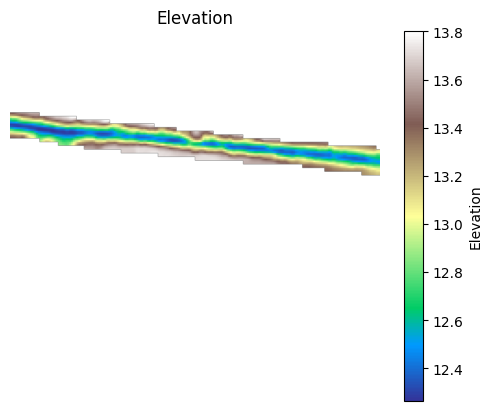

tensor(13.1187)


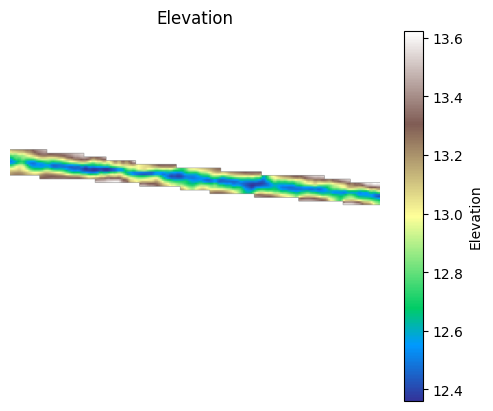

tensor(13.6425)


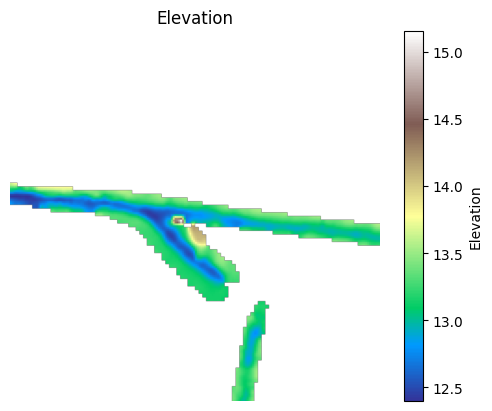

tensor(13.4201)


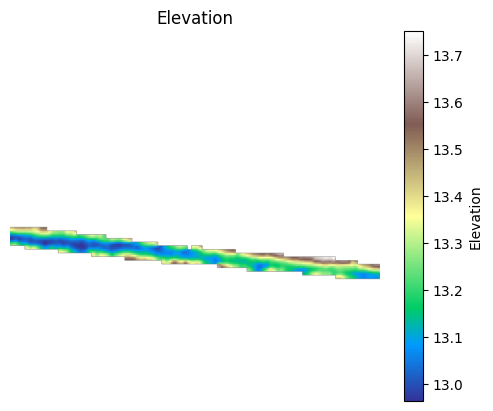

tensor(13.6360)


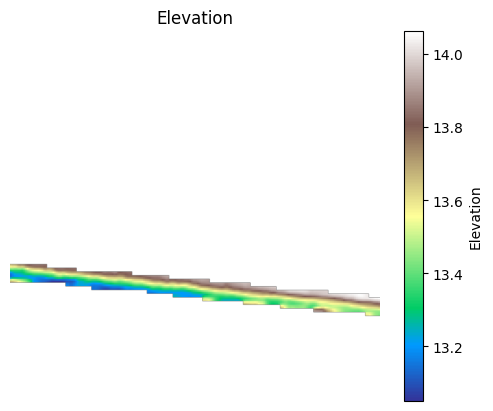

tensor(14.0632)


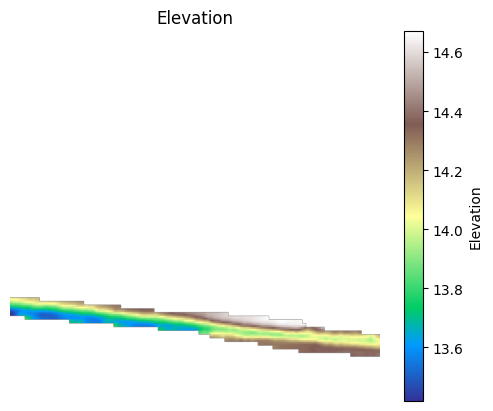

tensor(14.2175)


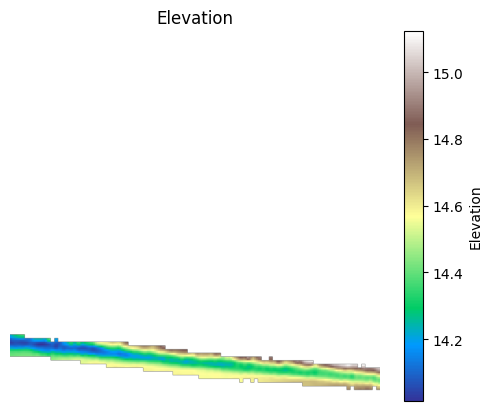

tensor(15.0175)


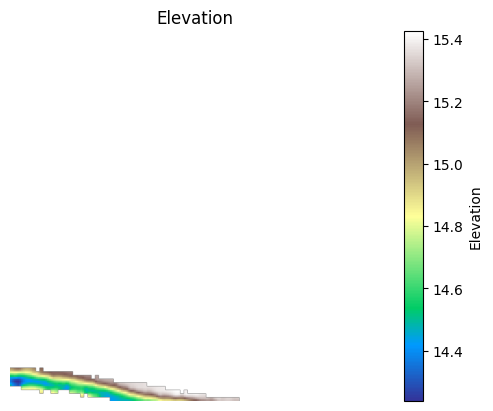

tensor(13.3864)


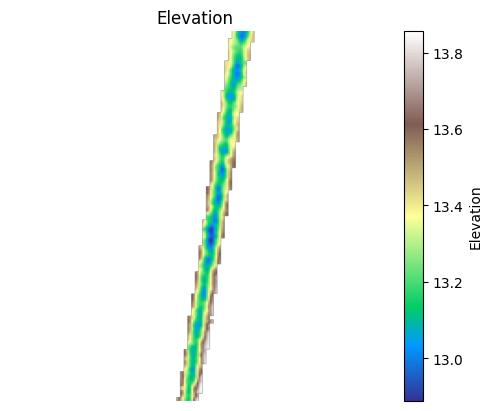

tensor(14.5245)


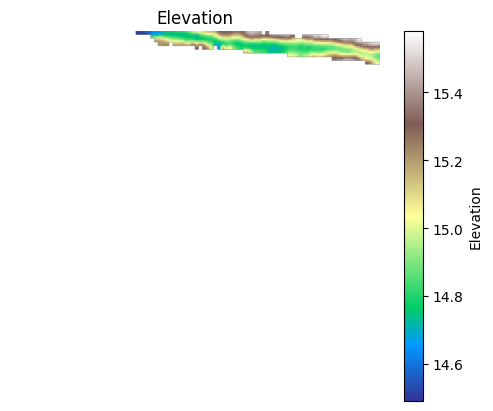

tensor(15.2566)


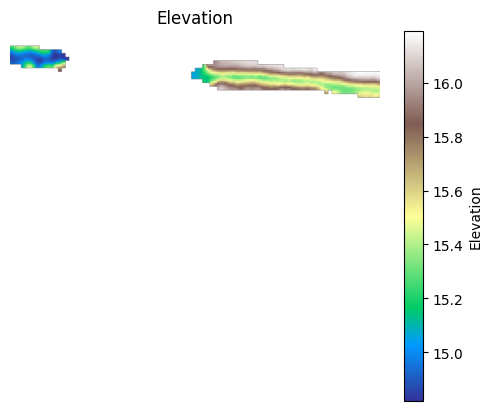

tensor(16.1975)


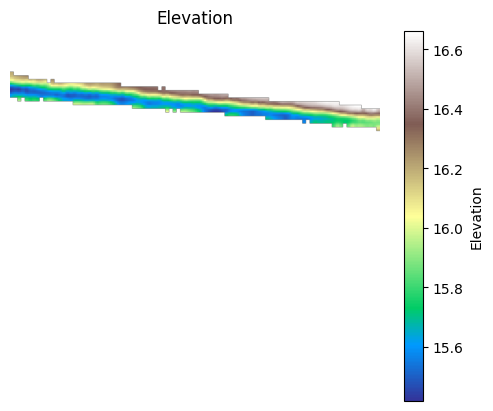

tensor(16.3565)


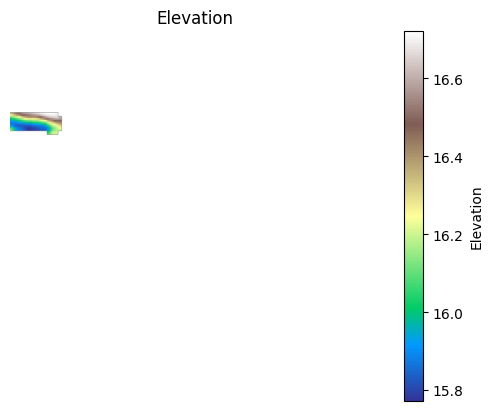

tensor(13.7267)


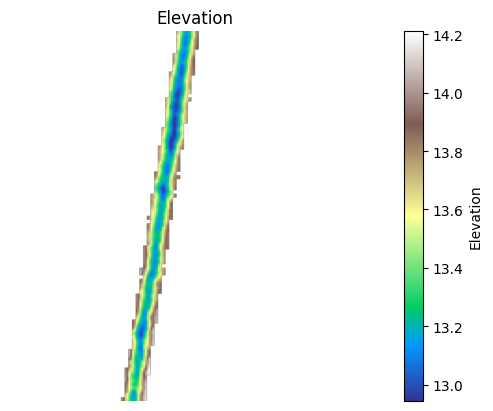

tensor(14.)


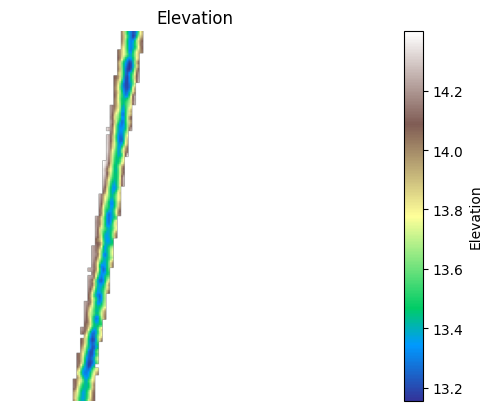

tensor(14.6700)


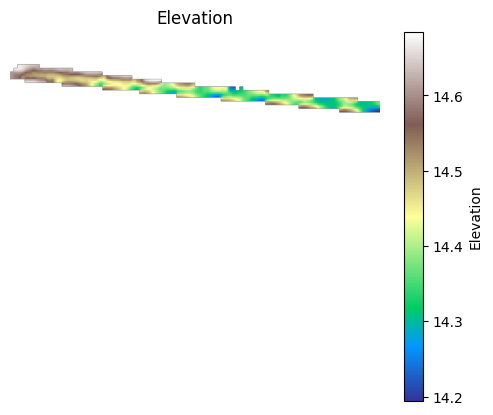

tensor(14.3892)


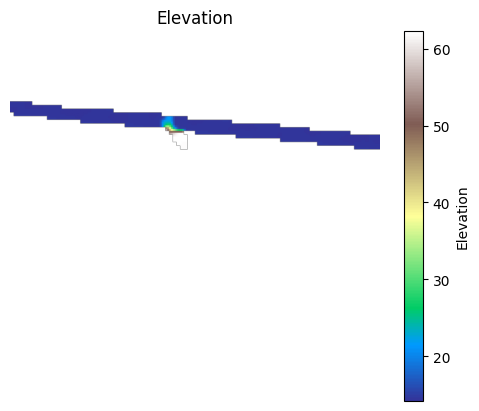

tensor(14.4600)


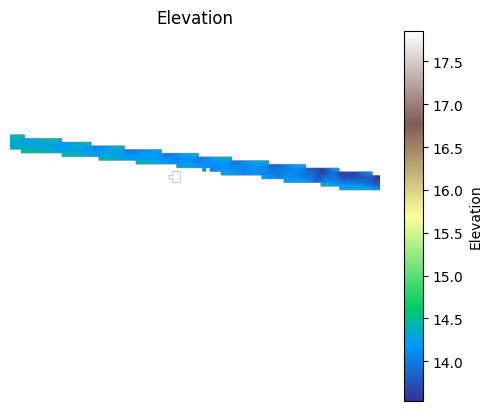

tensor(14.1088)


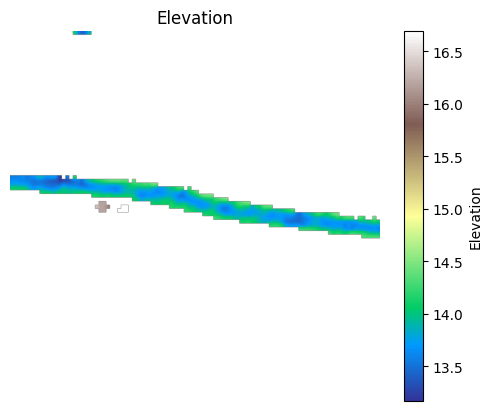

tensor(18.7100)


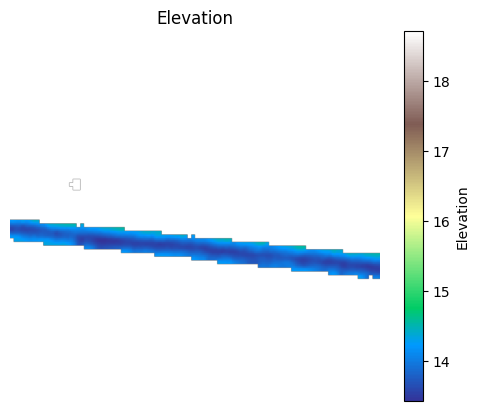

tensor(14.2615)


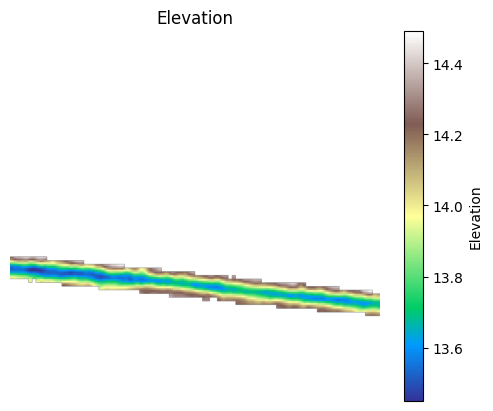

tensor(14.1180)


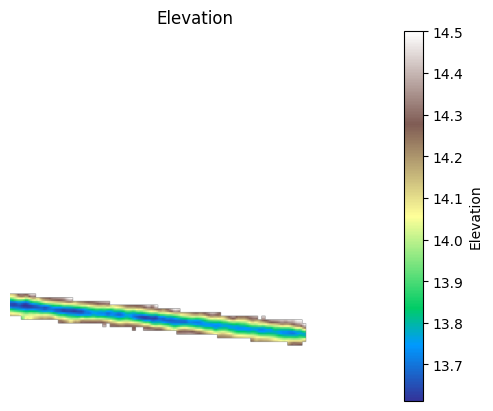

tensor(14.7100)


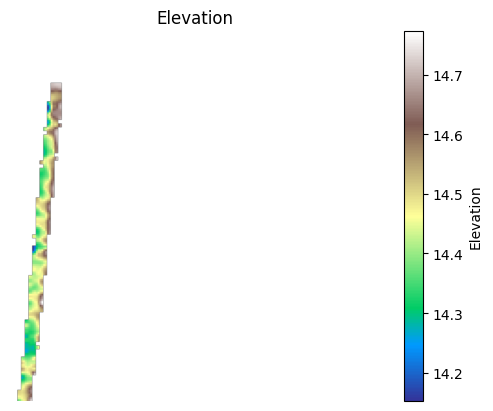

tensor(14.7200)


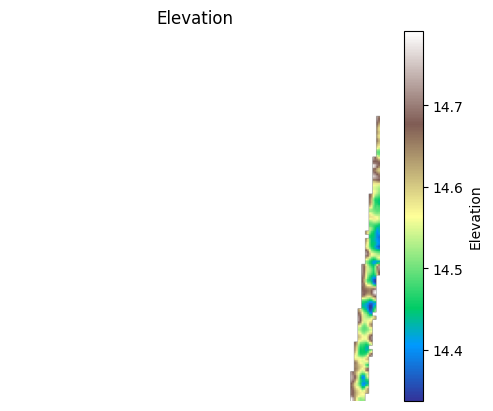

tensor(14.2858)


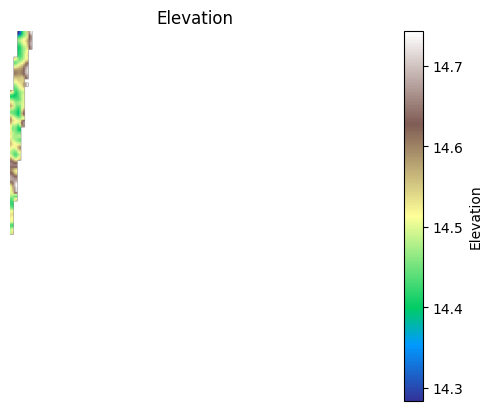

tensor(14.7547)


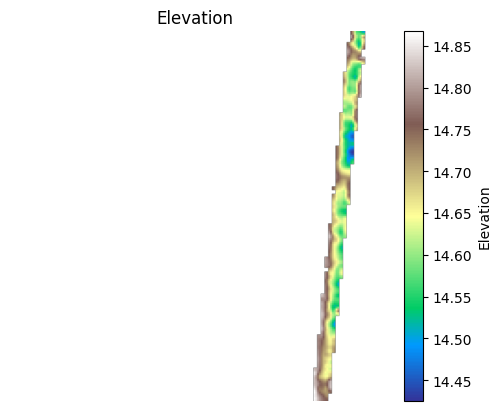

In [ ]:
for segment in segments:
    mask = ~torch.isnan(segment)
    if mask.any():
        print(segment[mask][0])
    if not mask.any():
        continue
    show_elevation(segment)